<h1>Power System Analysis and Optimization (5XWA0) - Practice</h1>
<h2>Simple unit commitment in PYOMO</h2>

<b>MSc Irena Dukovska</b> <br />
  Electrical Energy Systems Group <br />
  Department of Electrical Engineering <br />
  Eindhoven University of Technology <br />
  (i.dukovska@tue.nl) <br /><br />


<h2>Introduction</h2>

In this tutorial we will be developing a model in Python in order to solve and examine the solution of a simple form of the Unit Commitment problem.

The optimization problem is formulated as follows:

\begin{align}
&\text{Minimize} \ C = \sum_{i}(a_i \cdot u_i +b_i \cdot P_i + c_i \cdot P_i^2) \\
&\text{subject to:} \\
&\sum_{i} P_i = D \ \forall i \\
&P_i^{min} \cdot u_i \leq P_i \leq P_i^{max} \cdot u_i \ \forall i \\
&P_i \geq 0 \ \forall i \\
&u_i \in \left\{0,1 \right\}
\end{align}

The basis for this model is the economic dispatch with generation constraints. Note that a new variable ($u_i$) that can only take the values 0 or 1 was added, affecting both the constraints and the objective function. This is no longer a continuous (quadratic programming) problem. The goal of the optimization problem is not only to find the optimal power output of the units as in the economic dispatch problem, but also the optimal set of units that must be online in order to serve the load at minimum cost.

In [76]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy

In [72]:
UnitData = pd.read_excel('UC_input.xlsx', sheet_name='Units', index_col = 0)
UnitData

,a,b,c,Min,Max
,,,,,
Unit1,500,5.3,0.004,200,450
Unit2,400,5.5,0.006,150,350
Unit3,200,5.8,0.009,100,225


In [73]:
def unit_commitment(D):

    model = ConcreteModel()

    model.I = Set(ordered=True, initialize=UnitData.index)

    model.a = Param(model.I, within=NonNegativeReals, mutable=True)
    model.b = Param(model.I, within=NonNegativeReals, mutable=True)
    model.c = Param(model.I, within=NonNegativeReals, mutable=True)

    model.Pmax = Param(model.I, within=NonNegativeReals, mutable=True)
    model.Pmin = Param(model.I, within=NonNegativeReals, mutable=True)

    model.u = Var(model.I, within=Binary)
    model.P = Var(model.I, within=PositiveReals)

    for i in model.I:
        model.a[i] = UnitData.loc[i, 'a']
        model.b[i] = UnitData.loc[i, 'b']
        model.c[i] = UnitData.loc[i, 'c']
        model.Pmax[i] = UnitData.loc[i, 'Max']
        model.Pmin[i] = UnitData.loc[i, 'Min']

    def cost_rule(model):
        return sum(model.a[i]*model.u[i] + model.b[i]*model.P[i]+model.c[i]*model.P[i]*model.P[i] for i in model.I)

    def min_rule(model, i):
        return model.Pmin[i]*model.u[i] <= model.P[i]

    def max_rule(model, i):
        return model.P[i] <= model.Pmax[i]*model.u[i]

    def pbalance_rule(model):
        return sum(model.P[i] for i in model.I) == D


    model.cost = Objective(rule=cost_rule)
    model.min_out_constraints = Constraint(model.I, rule = min_rule)
    model.max_out_constraints = Constraint(model.I, rule = max_rule)
    model.balance = Constraint(rule=pbalance_rule)

    opt = SolverFactory('gurobi')
    results = opt.solve(model)

    return model

In [74]:
load_step = 10
Load_levels = numpy.arange(UnitData['Min'].min(), UnitData['Max'].sum(), load_step)
results_df = pd.DataFrame(index=Load_levels, columns=['Cost', 'Unit1', 'Unit2', 'Unit3'], dtype=float)

for D in Load_levels:
    model = unit_commitment(D)
    results_df.loc[D, 'Cost'] = model.cost()
    for i in model.I:
        results_df.loc[D, i] = model.u[i].value

In [75]:
results_df

,Cost,Unit1,Unit2,Unit3
100,870.00,0.0,0.0,1.0
110,946.90,0.0,0.0,1.0
120,1025.60,0.0,0.0,1.0
130,1106.10,0.0,0.0,1.0
140,1188.40,0.0,0.0,1.0
...,...,...,...,...
980,8283.34,1.0,1.0,1.0
990,8378.06,1.0,1.0,1.0
1000,8473.50,1.0,1.0,1.0
1010,8569.66,1.0,1.0,1.0


In [90]:
#  We now want to see which units are online for each load level.

# We can create a numpy array from the data frame which we later transpose
status_table = results_df[['Unit1', 'Unit2', 'Unit3']].to_numpy()
status_table = numpy.transpose(status_table)
unit_dim = status_table.shape[0] # Number of units
level_dim = status_table.shape[1] #


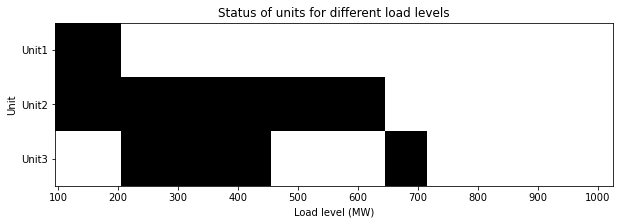

In [106]:
plt.figure(figsize=(10,3))
plt.imshow(status_table, aspect='auto',cmap='gray')
plt.title('Status of units for different load levels')
plt.ylabel('Unit')
plt.xlabel('Load level (MW)')
plt.xticks(numpy.arange(0,level_dim,step=10),numpy.arange(Load_levels[0],Load_levels[-1],step=100))
plt.yticks(numpy.arange(0,unit_dim,step=1),UnitData.index.values)

plt.show()